In [36]:
import cv2 
import numpy as np
import glob
import os
from itertools import combinations 
from itertools import product
import random
import matplotlib.pyplot as plt

In [70]:
import keras 
from keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Input, Flatten, Subtract, merge,Conv2D,Lambda
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.models import Model,Sequential
#from keras.initializers.h as 

from keras.regularizers import l2 

In [57]:
path_input_images =  '/tensorflow/IITD Database/'

In [39]:
folder_name_list = np.sort(os.listdir(path_input_images))
out1= np.zeros((4000,96,96,3),'float')
out2= np.zeros((4000,96,96,3),'float')

pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))

count = 0
y = []
for folder_name in folder_name_list[:100]:
    
    for i in range (len(pos_comb1)):
        
        img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
        img1_0 = cv2.resize(img1_0,(96,96))
        
        
        img1_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
        img1_1 = cv2.resize(img1_1,(96,96))
        out1[count]  = img1_0
        out2[count]  = img1_1
        count = count+1
        y.append(0.0)
        
        img2_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)+'.bmp')
        img2_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)+'.bmp')
        img2_0 = cv2.resize(img2_0,(96,96))
        img2_1 = cv2.resize(img2_1,(96,96))
        out1[count]  = img2_0
        out2[count]  = img2_1
        y.append(0.0)
        count = count+1
        
        img3_0 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
        img3_1 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp') 
        
        img3_0 = cv2.resize(img3_0,(96,96))
        img3_1 = cv2.resize(img3_1,(96,96))
        out1[count]  = img3_0
        out2[count]  = img3_1
        y.append(1.0)
        count = count+1
        
        folder_name1 = str(int(folder_name) + 3).zfill(3) 
        
        img4_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
        img4_1 = cv2.imread(path_input_images + folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp') 
        img4_0 = cv2.resize(img4_0,(96,96))
        img4_1 = cv2.resize(img4_1,(96,96))
        out1[count]  = img4_0
        out2[count]  = img4_1
        y.append(1.0)
        count = count+1
        #print(count) 

In [40]:

out1 = out1/255.
out2 = out2/255.

In [41]:
print ("X_train shape: " + str(out1.shape))


X_train shape: (4000, 96, 96, 3)


In [42]:
path_input_images + folder_name + '/'+ str(neg_comb1[1][0]).zfill(2)+'.bmp'

'/tensorflow/IITD Database/100/02.bmp'

In [43]:
path_input_images + folder_name + '/'+ str(neg_comb1[1][1]).zfill(2)+'.bmp'

'/tensorflow/IITD Database/100/09.bmp'

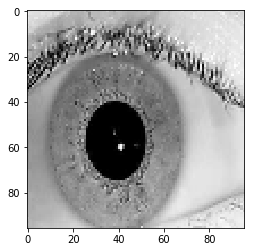

In [44]:
plt.imshow(out1[3])

In [63]:
initialize_weights = 'he_normal'
initialize_bias = 'he_normal'

In [71]:
def Siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction,name='Siamese_model')
    
    # return the model
    return siamese_net

In [72]:
siamese_model = Siamese_model((96,96,3))

In [73]:
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         17988928    input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_5[1][0]               
          

In [74]:
optimizer = keras.optimizers.Adam(lr = 0.00006)
siamese_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ["accuracy"])
#siamese_model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.SGD(lr=0.001),metrics = ['accuracy'])


In [75]:
siamese_model.fit([out1,out2],y,epochs=100, batch_size = 4)

Epoch 1/100
4000/4000 [==============================] - 48s 12ms/step - loss: 2.9696 - acc: 0.8908
Epoch 2/100
4000/4000 [==============================] - 46s 12ms/step - loss: 1.1622 - acc: 0.9555
Epoch 3/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.7664 - acc: 0.9662
Epoch 4/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.5635 - acc: 0.9752
Epoch 5/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.4449 - acc: 0.9795
Epoch 6/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.3686 - acc: 0.9845
Epoch 7/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.3112 - acc: 0.9852
Epoch 8/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.2876 - acc: 0.9870
Epoch 9/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.2553 - acc: 0.9882
Epoch 10/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.2370 - acc: 0.9892

4000/4000 [==============================] - 46s 12ms/step - loss: 0.0805 - acc: 0.9945
Epoch 83/100
4000/4000 [==============================] - 46s 12ms/step - loss: 0.0779 - acc: 0.9958
Epoch 84/100
4000/4000 [==============================] - 46s 12ms/step - loss: 0.0645 - acc: 0.9990
Epoch 85/100
4000/4000 [==============================] - 46s 12ms/step - loss: 0.0698 - acc: 0.9970
Epoch 86/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.0627 - acc: 0.9985
Epoch 87/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.0646 - acc: 0.9978
Epoch 88/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.0575 - acc: 0.9992
Epoch 89/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.0763 - acc: 0.9947
Epoch 90/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.0668 - acc: 0.9982
Epoch 91/100
4000/4000 [==============================] - 47s 12ms/step - loss: 0.0684 - acc: 0.9963
Epo